# Separating Radiation Modes

There are two linearly independent radiaiton modes for each value of beta.  We have conditions on how to choose these.  Here we see if paper's method of separation works.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from slab import SlabExact
from fiberamp.fiber.microstruct.bragg import plotlogf
from scipy.linalg import eig
from scipy.optimize import newton


In [2]:
A = SlabExact(ns=[1, 2, 1], symmetric=True)  # Need symmetric interfaces for properties on M inverse to hold

In [3]:
# Create transmission matrices for two betas

beta1 = .5 * A.K_low
beta2 = .1 * A.K_low

M1 = A.transmission_matrix(beta1, Ztype_far_left='standard', Ztype_far_right='standard')
M2 = A.transmission_matrix(beta2, Ztype_far_left='standard', Ztype_far_right='standard')

M1, M2

(array([[3.06154590e-01+1.19907135j, 4.42746748e-16+0.72904234j],
        [4.45156951e-16-0.72904234j, 3.06154590e-01-1.19907135j]]),
 array([[9.07445051e-01+0.8517093j , 3.27202499e-16+0.74085441j],
        [3.24509370e-16-0.74085441j, 9.07445051e-01-0.8517093j ]]))

In [6]:
Ls, Vs = eig(M1)

In [7]:
Vs.T

array([[ 0.94708304+0.00000000e+00j, -0.32098865-2.13821391e-16j],
       [-0.32098865+1.87350135e-16j,  0.94708304+0.00000000e+00j]])

In [8]:
Vs.T @np.diag(Ls) @ np.linalg.inv(Vs.T), M1

(array([[ 3.06154590e-01+1.19907135j, -4.93408303e-16+0.72904234j],
        [-4.37986728e-16-0.72904234j,  3.06154590e-01-1.19907135j]]),
 array([[3.06154590e-01+1.19907135j, 4.42746748e-16+0.72904234j],
        [4.45156951e-16-0.72904234j, 3.06154590e-01-1.19907135j]]))

In [16]:
# Get coefficients in first and last region for radiation modes from those betas

C1 = A.coefficients(beta1, mode_type='radiation', sign='1')
C2 = A.coefficients(beta2, mode_type='radiation', sign='-1')

v1, w1 = C1.T[0], C1.T[-1]
v2, w2 = C2.T[0], C2.T[-1]

# Note w1 = M1 @ v1, w2 = M2 @ v2
w1, M1@v1, w2, M2@v2

(array([0.22374757+0.33029073j, 0.22374757-0.33029073j]),
 array([0.22374757+0.33029073j, 0.22374757-0.33029073j]),
 array([0.02314625-0.39827025j, 0.02314625+0.39827025j]),
 array([0.02314625-0.39827025j, 0.02314625+0.39827025j]))

In [17]:
# Check conditions on these coefficients.
# Note we have moved from just wanting these to hold on beta1 = beta2 to any choice of beta1 and beta2,
# based on numerical investigations.

S = np.array([[0,1],[1,0]])
J = np.array([[0,1],[-1,0]])

# Condition for diagonalization: these should be opposite
print(v2.T @ S @ v1, w2.T @ S @ w1)

# Condition for existence: these should be equal
print(v2.T @ J.T @ v1, w2.T @ J.T @ w1)

(0.252732110476405+0j) (-0.252732110476405+0j)
0.19351398909772127j 0.19351398909772127j


In [18]:
# Reformulate above conditions in terms of matrices
DiagMat = S + M2.T @ S @ M1  # uses w = Mv for both vector groups
ExistMat = J - M2.T @ J @ M1

# Both of these should give zero
v2.T @ DiagMat @ v1,  v2.T @ ExistMat @ v1

((1.190825216212943e-12+0j), (-6.938893903907228e-18+3.470002063465927e-13j))

In [19]:
ExistMat

array([[ 0.26740515+0.43474989j,  0.24103554+0.82733665j],
       [-0.24103554+0.82733665j, -0.26740515+0.43474989j]])

In [89]:
# Vectors are 2d, DiagMat @ v1 and ExistMat @ v1 are both perp to v2, so they should be parallel

(DiagMat @ v1 )/ (ExistMat @ v1)

array([-7.92681356e-14-3.48143142j,  7.87374914e-14-3.48143142j])

In [90]:
# This means that v1 is an eigenvector for the generalized eigenproblem DiagMat @ v1 = lambda ExistMat @ v1 
AB = np.linalg.inv(ExistMat) @ DiagMat
ls, vs = eig(AB)
ls, vs.T

(array([-4.44089210e-16-3.48143142j,  1.11022302e-16-3.38342045j]),
 array([[ 0.70710678+0.j        , -0.2622589 +0.65667364j],
        [-0.54496684+0.45056759j,  0.70710678+0.j        ]]))

In [91]:
vs.T[0]/v1

array([0.99408427+1.46744306j, 0.99408427+1.46744306j])

In [92]:
# Second eigenvector
vs.T[1]

array([-0.54496684+0.45056759j,  0.70710678+0.j        ])

This is true for a fixed M1 v1 for all choices of M2 v2... seems like more can be said.
Right, we don't want v1 to change as we pick different M2, v2 ... at least no more than a scaling. So let's check that.  Pick a third, beta3, M3, v3, and see if v1 stays the same

In [93]:
# Third beta etc

beta3 = .8 * A.K_low
M3 = A.transmission_matrix(beta3, Ztype_far_left='standard', Ztype_far_right='standard')
C3 = A.coefficients(beta3, mode_type='radiation', sign='-1')

v3, w3 = C3.T[0], C3.T[-1]

In [108]:
# Build new conditions for beta1 combined with beta3
DiagMat2 = S + M3.T @ S @ M1  
ExistMat2 = J - M3.T @ J @ M1

# Both of these also give zero
v3.T @ DiagMat2 @ v1,  v3.T @ ExistMat2 @ v1

((-4.2299497238218464e-13-4.163336342344337e-17j),
 (-1.3877787807814457e-17-3.325117958752344e-14j))

In [109]:
# These should be parallel again
(DiagMat2 @ v1 )/ (ExistMat2 @ v1)

array([ 1.86986310e-12+2.28902316j, -1.87030327e-12+2.28902316j])

In [110]:
# So v1 is also an eigenvector for the generalized eigenproblem DiagMat2 @ v1 = lambda ExistMat2 @ v1 
AB2 = np.linalg.inv(ExistMat2) @ DiagMat2
ls2, vs2 = eig(AB2)
ls2, ls, ls2/ls

(array([ 8.88178420e-16+2.28902316j, -6.55484962e-16+1.09593445j]),
 array([-4.44089210e-16-3.48143142j,  1.11022302e-16-3.38342045j]),
 array([-0.65749483+1.71249118e-16j, -0.32391317-1.83105643e-16j]))

In [111]:
vs2.T[0]/v1

array([0.99408427+1.46744306j, 0.99408427+1.46744306j])

In [113]:
# So all of these generalized eigenproblems have the same eigenvectors?  That seems like a lot!
# Is the second eigenvector also the same?

vs2.T[1], vs.T[1]

(array([-0.54496684+0.45056759j,  0.70710678+0.j        ]),
 array([-0.54496684+0.45056759j,  0.70710678+0.j        ]))

In [114]:
# They are.  Dang.

In [115]:
vs2.T[0], vs.T[0]

(array([ 0.70710678+0.j        , -0.2622589 +0.65667364j]),
 array([ 0.70710678+0.j        , -0.2622589 +0.65667364j]))

In [116]:
# Are they the same matrix?
AB2/AB

array([[ -0.49435059+1.21559620e-01j, -12.17301253-1.33031373e-14j],
       [-12.17301253+2.08415818e-14j,  -0.49435059-1.21559620e-01j]])

In [ ]:
# No, but the diag of AB2 is a constant multiple of the diag of AB, same for antidiag



In [63]:
# So it seems like all the matrices have the same eigenvectors..., although if beta1 = beta2 we saw
# that the ExistMat was the zero matrix...
# so that sets RHS of DiagMat @ v1 = lambda ExistMat @ v1 to zero
# are all of these vectors in the null space of DiagMat?

DiagMat2@ v1

array([0.35752915+0.67728131j, 0.35752915-0.67728131j])

In [64]:
# Same betas  (enforced by using M1 for both M matrices)

DiagMat3 = S + M1.T @ S @ M1  
ExistMat3 = J - M1.T @ J @ M1

ExistMat3, DiagMat3 @ v1

(array([[-3.03068453e-17+2.77555756e-17j,  8.88178420e-16+0.00000000e+00j],
        [-7.77156117e-16+0.00000000e+00j,  5.19592003e-17+0.00000000e+00j]]),
 array([0.929087+0.33433856j, 0.929087-0.33433856j]))

In [51]:
# No, doesn't need to be in null space, just removes condition for existence, it's satisfied for any v1 and v2
# What about same betas in general? Same beta, different classes

beta = .7* A.K_low
M = A.transmission_matrix(beta, Ztype_far_left='standard', Ztype_far_right='standard')

Cs1 = A.coefficients(beta, mode_type='radiation', sign='1')
Cs2 = A.coefficients(beta, mode_type='radiation', sign='-1')

vss1, wss1 = Cs1.T[0], Cs1.T[-1]
vss2, wss2 = Cs2.T[0], Cs2.T[-1]


In [52]:
DiagMats = S + M.T @ S @ M
ExistMats = J - M.T @ J @ M

ExistMats

array([[ 3.49979094e-17+0.00000000e+00j,  2.22044605e-16+1.11022302e-16j],
       [-3.33066907e-16-1.66533454e-16j,  4.61797585e-17-5.55111512e-17j]])

In [53]:
# Different classes go to zero here, so it diagonalizes system.

vss2.T @ DiagMats @ vss1

(1.3533618670180658e-12-1.3877787807814457e-17j)

In [54]:
# Same classes don't, and in fact this is the coefficient in front of A(w) (or B(w) for other class).

vss1.T @ DiagMats @ vss1

(0.6366197723671112-1.3877787807814457e-17j)

In [55]:
# We could plot this

def Expansion_Coeff(beta, sign='+1'):
    C = A.coefficients(beta, mode_type='radiation', sign=sign)
    v, w = C.T[0], C.T[-1]
    return v.T @ S @ v + w.T @ S @ w

In [56]:
Expansion_Coeff(.5*A.K_low)

(0.6366197723675274+0j)

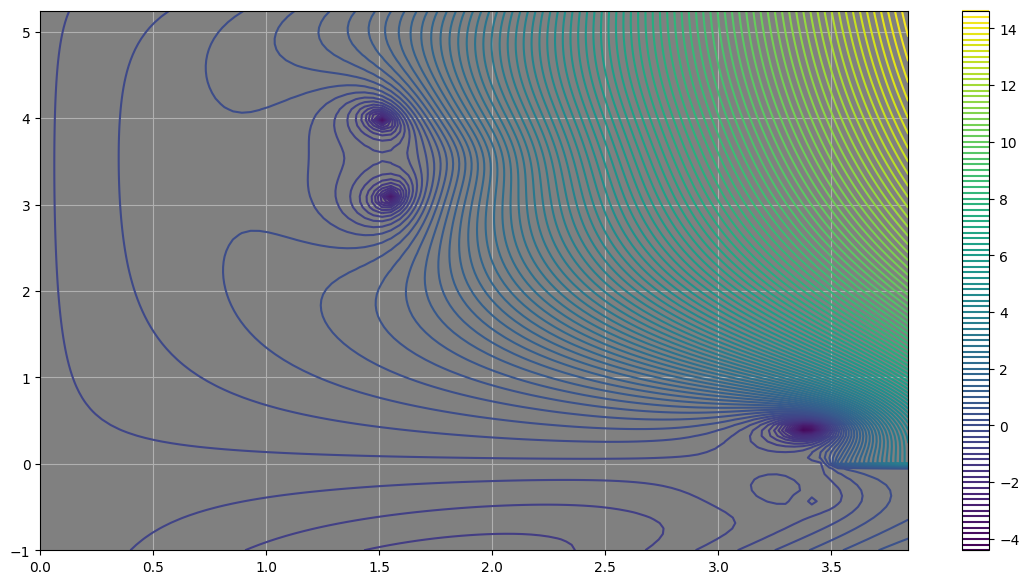

In [70]:
plotlogf(Expansion_Coeff, 0, 1.1*A.K_low, -1, 1.5*A.K_low, loop=True, iref=100, rref=100, levels=100)

In [58]:
beta1 = newton(Expansion_Coeff, np.array([3.3+.4j]))[0]
beta1

(3.3944395670175984+0.40913926873676726j)

In [28]:
def Trans_Entry(beta):
    M = A.transmission_matrix(beta, Ztype_far_left='standard', Ztype_far_right='standard')
    return M[1,1]

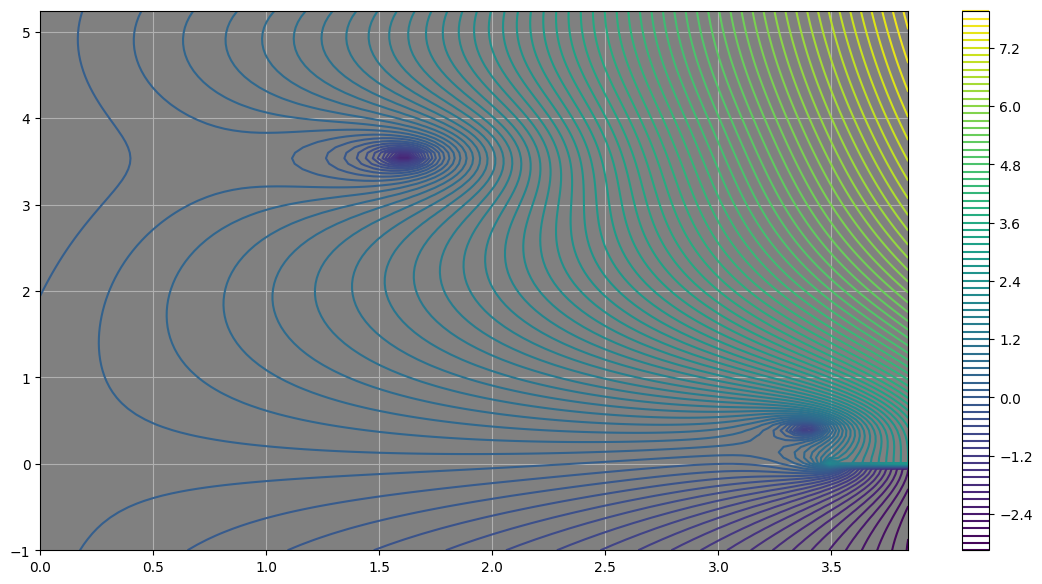

In [29]:
plotlogf(Trans_Entry, 0, 1.1*A.K_low, -1, 1.5*A.K_low, iref=100, rref=100, levels=100, loop=True)

In [30]:
beta2 = newton(A.determinant, np.array([3.4+.4j]), args=('TE', 'leaky'))[0]
beta2

(3.394439567017598+0.40913926873676804j)

In [31]:
beta1-beta2

(4.440892098500626e-16-7.771561172376096e-16j)

So one of the zeros appears to be exactly the same, but others are not.  Closer look

#### Expansion coefficient one

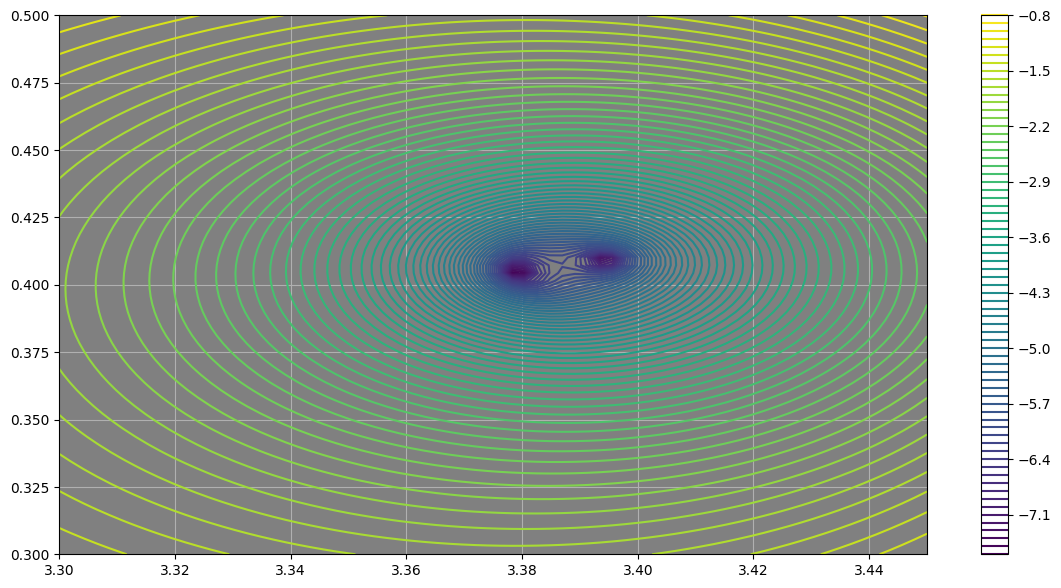

In [71]:
plotlogf(Expansion_Coeff, 3.3, 3.45, 0.3, .5, loop=True, iref=70, rref=70, levels=70)

### Leaky mode one

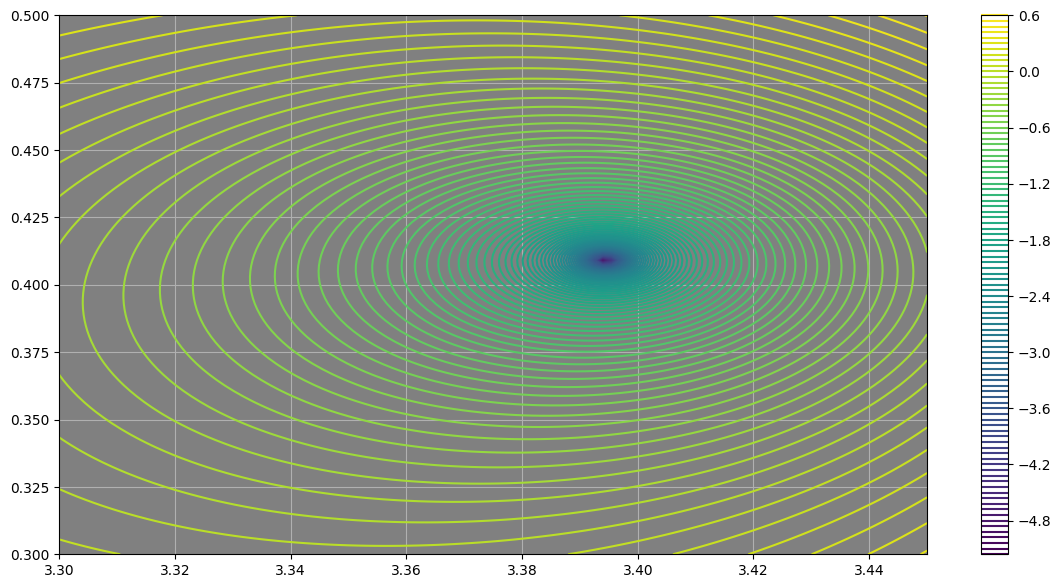

In [72]:
plotlogf(Trans_Entry, 3.3, 3.45, 0.3, .5, iref=100, rref=100, levels=100, loop=True)

### Other zero zoom in

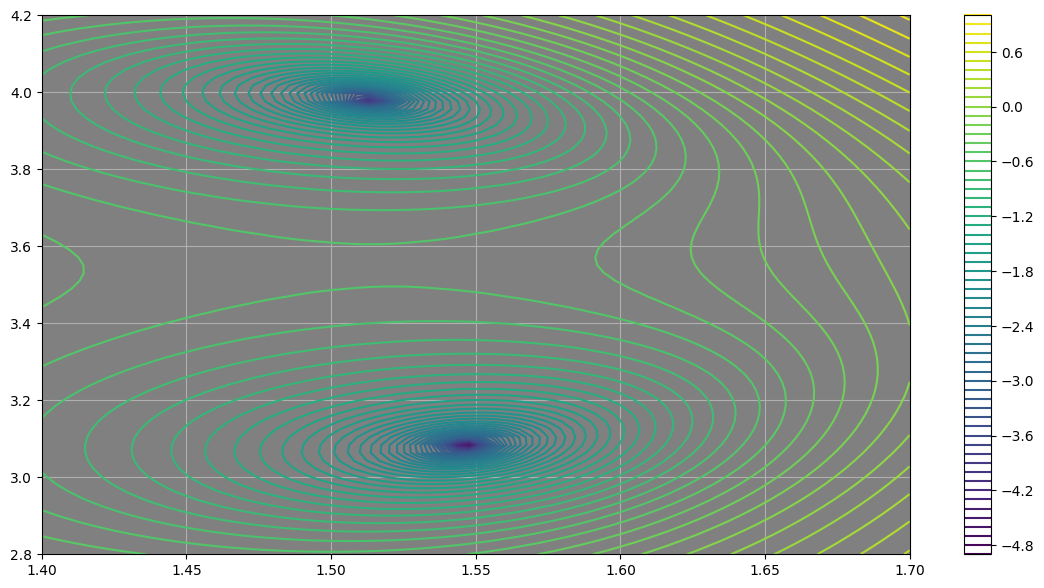

In [75]:
plotlogf(Expansion_Coeff, 1.4, 1.7, 2.8, 4.2, loop=True, iref=70, rref=70, levels=70)

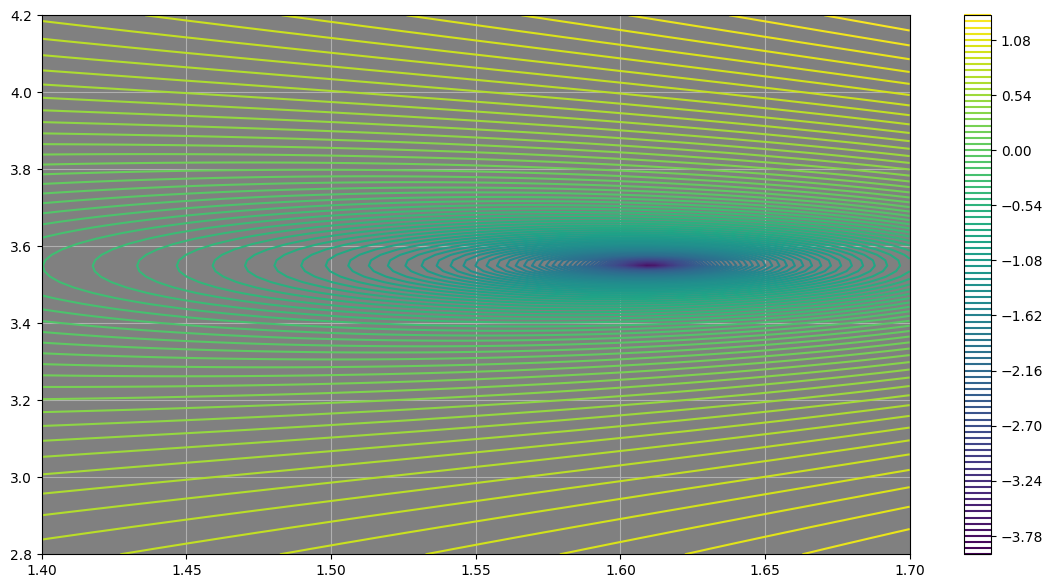

In [76]:
plotlogf(Trans_Entry, 1.4, 1.7, 2.8, 4.2, iref=100, rref=100, levels=100, loop=True)